In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from lib.stabilizer import measurement_gadgets, StabilizerCode, stabilizer_circuits
from lib.color_compass import *
from lib.decoder import checkmatrix,pL_from_checkmatrix
from lib.stim2pymatching import estimate_pL_noisy_graph
import stimcirq
from typing import *
from cirq.contrib.svg import SVGCircuit
import networkx as nx
import time
from tqdm import tqdm
import scipy.stats as ss
import pickle
from pymatching import Matching
from ldpc import bposd_decoder
from CompassCode import Lattice2D, random_pauli, print_pauli_error, pcheck_clipX, pcheck_clipZ

%load_ext autoreload
%autoreload 2

In [2]:
rng = np.random.default_rng(72348)

In [12]:
dims = [3,5,7,9,11,15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 10
phys_err_rates_range = np.linspace(0.0001, 0.12, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in tqdm(dims):
    for fix_num in range(num_gauge_fixings):
        lat = compass_to_surface(dim, dim)
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 0
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 0
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                print(bpd_X.log_prob_ratios)
                weightsX = np.array(bpd_X.log_prob_ratios)/np.linalg.norm(bpd_X.log_prob_ratios)
                weightsZ = np.array(bpd_Z.log_prob_ratios)/np.linalg.norm(bpd_Z.log_prob_ratios)
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    # print(dim, fix_num, i)
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/6 [00:00<?, ?it/s]

[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[13.54184821 18.05579762 13.54184821 13.54184821 18.05579762 13.54184821
 13.54184821 18.05579762 13.54184821]
[

 17%|█▋        | 1/6 [00:04<00:24,  4.85s/it]

[3.36303051 4.48404068 3.36303051 3.36303051 4.48404068 3.36303051
 3.36303051 4.48404068 3.36303051]
[3.36303051 4.48404068 3.36303051 3.36303051 4.48404068 3.36303051
 3.36303051 4.48404068 3.36303051]
[3.36303051 4.48404068 3.36303051 3.36303051 4.48404068 3.36303051
 3.36303051 4.48404068 3.36303051]
[3.36303051 4.48404068 3.36303051 3.36303051 4.48404068 3.36303051
 3.36303051 4.48404068 3.36303051]
[3.36303051 4.48404068 3.36303051 3.36303051 4.48404068 3.36303051
 3.36303051 4.48404068 3.36303051]
[ 3.08277797  2.24202034 -0.28025254  3.08277797  4.76429322  3.9235356
  4.76429322  5.60505085  3.9235356 ]
[3.36303051 4.48404068 3.36303051 3.36303051 4.48404068 3.36303051
 3.36303051 4.48404068 3.36303051]
[2.25076113e+00 4.48840252e+00 4.49707502e+00 2.25076113e+00
 2.24202034e+00 4.37894598e-03 2.25076113e+00 2.24202034e+00
 4.37894598e-03]
[2.25076113e+00 4.48840252e+00 4.49707502e+00 2.25076113e+00
 2.24202034e+00 4.37894598e-03 2.25076113e+00 2.24202034e+00
 4.37894598e-03]


 33%|███▎      | 2/6 [00:12<00:25,  6.34s/it]

[ 4.14040949e+00  6.21061445e+00  6.21061420e+00  4.14040961e+00
  4.14040973e+00  4.14040949e+00  6.21061445e+00  4.14040986e+00
  4.14040936e+00  6.16969102e-08  4.14040949e+00  6.21061445e+00
  4.14040986e+00  4.14040887e+00  6.16969102e-08  4.14040949e+00
  6.21061395e+00  4.14040936e+00  4.14040961e+00  4.14040949e+00
  6.21061358e+00  6.21061395e+00  4.14040961e+00 -4.14040973e+00
  4.14040949e+00]
[3.10530716 2.07020477 0.         0.         1.03510239 3.10530716
 4.14040955 2.07020477 0.         1.03510239 3.10530716 4.14040955
 4.14040955 2.07020477 1.03510239 3.10530716 4.14040955 4.14040955
 4.14040955 3.10530716 3.10530716 4.14040955 4.14040955 4.14040955
 3.10530716]
[ 6.16969102e-08 -3.08484451e-07  4.31878345e-07  2.07020527e+00
  2.07020588e+00  6.16969102e-08  1.85090727e-07  6.78665979e-07
  2.07020502e+00  2.07020588e+00  6.16969102e-08  1.85090727e-07
  2.07020477e+00  2.07020576e+00  2.07020588e+00  6.16969102e-08
  2.07020453e+00  2.07020477e+00 -2.07020490e+00  2

 33%|███▎      | 2/6 [00:15<00:30,  7.70s/it]

[1.49280735 2.98561471 5.97122941 5.97122941 2.98561471 0.
 1.49280735 1.49280735 0.         2.98561471 5.97122941 2.98561471
 2.98561471 4.47842206 4.47842206 2.98561471 2.98561471 5.97122941
 5.97122941 5.97122941 4.47842206 4.47842206 5.97122941 5.97122941
 5.97122941 5.97122941 2.98561471 1.49280735 4.47842206 5.97122941
 5.97122941 5.97122941 2.98561471 0.         1.49280735 4.47842206
 5.97122941 5.97122941 5.97122941 2.98561471 2.98561471 4.47842206
 4.47842206 5.97122941 5.97122941 5.97122941 5.97122941 5.97122941
 4.47842206]
[ 5.71469447 11.25997927 10.91083917 10.91083917 10.91083917  8.35116908
  8.5308995   5.71469447  5.5452848   4.93960975  5.27842911  8.52057876
  8.35116908  5.97122941  0.60567504  0.16940968  0.16940968  5.28874986
  4.92928901  8.35116908  5.97122941  0.60567504  0.16940968  0.16940968
  5.28874986  4.92928901  8.35116908  5.97122941  5.71469447  5.5452848
  4.93960975  5.27842911  8.52057876  8.35116908  5.97122941  5.71469447
 11.25997927 10.910839

KeyboardInterrupt: 

In [5]:
total_phys_err_rates_range = [np.sum([r, r * 0.1, r * 0.1]) for r in phys_err_rates_range]

In [6]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_bp_matching_surf_code', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

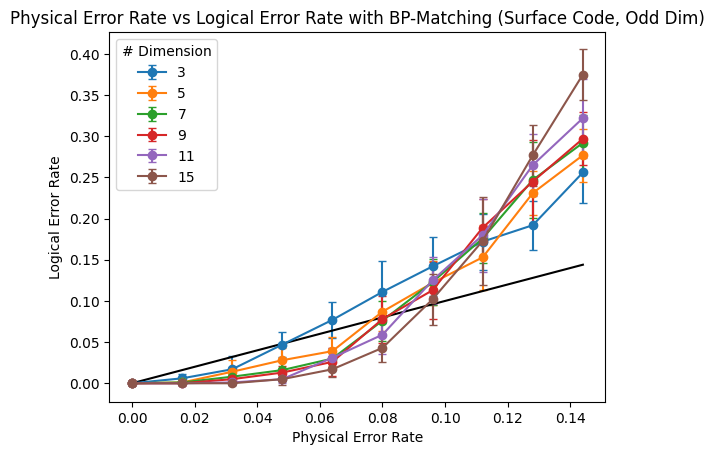

In [7]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate with BP-Matching (Surface Code, Odd Dim)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Dimension')

In [30]:
coloring = np.random.choice([-1,0,1],size=(10,),p=[0.8,0.1,0.1])
coloring

array([-1,  0,  1, -1, -1, -1,  1, -1, -1, -1])

In [17]:
dims = [3,5,7,9,11,15]
num_faces_colored = [dim**2 for dim in dims]
num_gauge_fixings = 10
phys_err_rates_range = np.linspace(0.0001, 0.12, 10)
num_errors = 100 
logical_errors = {dim : np.zeros((num_gauge_fixings, len(phys_err_rates_range))) for dim in dims}

for dim in dims:
    for fix_num in tqdm(range(num_gauge_fixings)):
        for i, phys_rate in enumerate(phys_err_rates_range):
            rates = [phys_rate, phys_rate * 0.1, phys_rate * 0.1] 
            error_probability = np.sum(rates)
            for num_error in range(num_errors):
                lat = Lattice2D(dim, dim)
                coloring = np.random.choice([-1,0,1], size=((dim - 1)**2), p=[(rates[0] + 0.5 * rates[1])/sum(rates), 0, (rates[1] * 0.5 + rates[2])/sum(rates)])
                lat.color_lattice(coloring)
                E = random_pauli(lat.size(), rates)
                while E == 'I' * lat.size():
                    E = random_pauli(lat.size(), rates)
                error = pauli2vector(E)
                pcheckX = lat.pcheckX() 
                pcheckZ = lat.pcheckZ()
                num_qubits = lat.size()
                pcheck = np.vstack((pcheckX, pcheckZ))
                syndromeZ = twisted_product(pcheckX, pauli2vector(E)) # Z-error syndrome 
                syndromeX = twisted_product(pcheckZ, pauli2vector(E)) # X-error syndrome 
                Hx = pcheck_clipX(pcheckX)
                Hz = pcheck_clipZ(pcheckZ)
                bpd_X = bposd_decoder(
                    Hz,
                    error_rate = error_probability,
                    channel_probs = [None],
                    max_iter = num_qubits, 
                    bp_method = "ms",
                    ms_scaling_factor = 0,
                    osd_method = "osd_cs",
                    osd_order = 3
                )
                bpd_Z = bposd_decoder(
                    Hx,
                    error_rate = error_probability, 
                    channel_probs = [None], 
                    max_iter = num_qubits, 
                    bp_method = "ms", 
                    ms_scaling_factor=0, 
                    osd_method = "osd_cs", 
                    osd_order = 3
                )
                bpd_X.decode(syndromeX)
                bpd_Z.decode(syndromeZ)
                weightsX = np.array(bpd_X.log_prob_ratios)/np.linalg.norm(bpd_X.log_prob_ratios)
                # if (np.max(weightsX) > 20000000):
                #     weightsX = np.zeros((lat.size(),))
                weightsZ = np.array(bpd_Z.log_prob_ratios)/np.linalg.norm(bpd_Z.log_prob_ratios)
                # if (np.max(weightsZ) > 20000000):
                #     weightsZ = np.zeros((lat.size(),))
                decodingX = Matching.from_check_matrix(Hx, weights=weightsX)
                decodingZ = Matching.from_check_matrix(Hz, weights=weightsZ)
                recoveryX = decodingX.decode(syndromeZ)
                recoveryZ = decodingZ.decode(syndromeX)
                recovery = np.concatenate((recoveryZ, recoveryX))
                corrected_error = pauli2vector(E) + recovery % 2 

                if (twisted_product(pauli2vector(lat.Lx), corrected_error) == 1) or (twisted_product(pauli2vector(lat.Lz), corrected_error) == 1):
                    # print(dim, fix_num, i)
                    logical_errors[dim][fix_num][i] += 1

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:32<04:50, 32.28s/it]


KeyboardInterrupt: 

In [18]:
total_phys_err_rates_range = [np.sum([r, r * 0.1, r * 0.1]) for r in phys_err_rates_range]

In [19]:
logical_error_probs = {int(dim) : [] for dim in logical_errors.keys()}
for dim in logical_errors.keys():
    for row in logical_errors[dim]:
        logical_error_probs[dim].append(row/num_errors)

with open('data/phys_vs_log_err_rate_bp_matching_ds_code', 'wb') as fp:
    pickle.dump(logical_error_probs, fp)

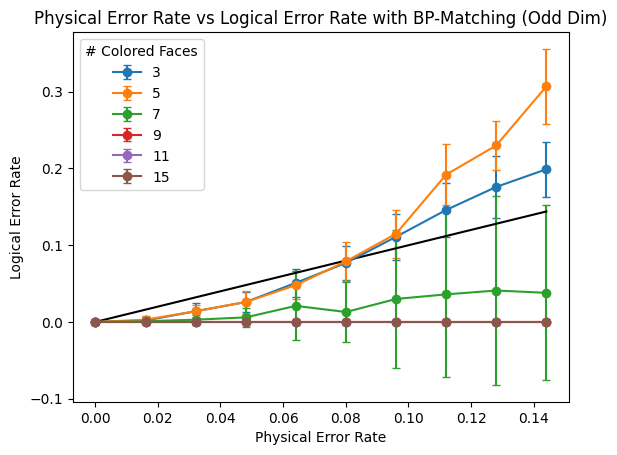

In [20]:
for dim in logical_error_probs.keys():
    logical_error_list = np.array(logical_error_probs[dim])
    logical_error_list_mean = np.mean(logical_error_list, axis=0)
    logical_error_list_std = np.std(logical_error_list, axis=0)
    plt.errorbar(total_phys_err_rates_range, logical_error_list_mean, yerr=logical_error_list_std, label=str(dim), capsize=3, fmt='o-')

plt.xlabel('Physical Error Rate')
plt.ylabel('Logical Error Rate')
plt.title('Physical Error Rate vs Logical Error Rate with BP-Matching (Odd Dim)')
plt.plot(total_phys_err_rates_range, total_phys_err_rates_range, color='black')
plt.legend(title='# Colored Faces')